In [11]:
import os
import torch
import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
import pickle

In [12]:
GNDTRUTH = "../data/taccruns/cameo_subset_gndtruth_pdbs/"
#DOE_PTH = "../data/taccruns/predictions-zDOE_no_ipa_during_pert/" #"../data/taccruns/predictions-zDOE/"
PTH_zDOE = "../data/taccruns/predictions-zDOE/"
PTH_zDOE_noIPA = "../data/taccruns/predictions-zDOE_no_ipa_during_pert/"

In [13]:
def get_proteins_in_pth(pth):
    list_proteins = []
    for file in os.listdir(pth):
        if not file[0:6] in list_proteins: list_proteins.append(file[0:6])
    return list_proteins
print( get_proteins_in_pth(DOE_PTH) )

['7mqy_A', '7tav_B', '7t9w_B', '7bcz_A']


In [14]:
# get cameo dict
with open('cameo_dict.pkl', 'rb') as f: cameo_dict = pickle.load(f)
stats = ['tmscore_model1','tmscore_model4','tmscore_model1_1iter',
         'tmscore_model1_struc_modu_s0firstblock_1iter','tmscore_model1_struc_modu_s0firstblock',
         'tmscore_model1_s0_after_struc_modu']

In [15]:
def tmscore(gnd_truth, modified):
    tmscore = -1
    os.system(f"./../tmscore/TMscore -infmt1 -1 -infmt1 -1 {gnd_truth} {modified} >> tmscore_temp_output")
    with open("tmscore_temp_output") as f:
        for line in f:
            if line.startswith("TM-score"):
                tmscore = float(line.split('=')[1].strip().split(' ')[0])
    os.system("rm tmscore_temp_output")
    return tmscore

def tmscore_barchart(protein):
    tmscore_stats = []
    for stat in stats:
        tmscore_stats.append(cameo_dict[protein][stat])
    wrapped_labels = [ label.replace('_', '\n') for label in stats ]
    ax = sns.barplot(x=wrapped_labels,y=tmscore_stats)
    ax.set_title(protein)
    #plt.show()

cos = nn.CosineSimilarity(dim=0)
def cosine_similarity(pth1, pth2):
    t1 = torch.flatten(torch.load(pth1, map_location=torch.device('cpu')))
    t2 = torch.flatten(torch.load(pth2, map_location=torch.device('cpu')))
    return cos(t1,t2)

def get_lspace_cos_sim_row(protein,i_zeroed,r_zeroed,compare_file_pth, list_lines, DOE_PTH): 
    data = []
    for r in range(4):
        if 0 in list_lines:
            file = DOE_PTH + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + f"s_line_0_r_{r}.pt"
            data.append( cosine_similarity(file,compare_file_pth) )
        for i in range(8):
            for l in [6,9]:
                if l in list_lines:
                    file = DOE_PTH + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + f"s_line_{l}_i_{i}_r_{r}.pt"
                    data.append( cosine_similarity(file,compare_file_pth) )
    return data

def get_lspace_cos_sim_grid(protein,i_zeroed,r_zeroed, list_lines, DOE_PTH):
    data = []
    ticks = []
    for r in range(4):
        if 0 in list_lines:
            compare_file_pth = DOE_PTH + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + f"s_line_0_r_{r}.pt"
            data.append( get_lspace_cos_sim_row(protein,i_zeroed,r_zeroed,compare_file_pth, list_lines, DOE_PTH) )
            ticks.append( f"r{r}     L{0}" ) #line name on plot
        for i in range(8):
            for l in [6,9]:
                if l in list_lines:
                    compare_file_pth = DOE_PTH + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + f"s_line_{l}_i_{i}_r_{r}.pt"
                    data.append( get_lspace_cos_sim_row(protein,i_zeroed,r_zeroed,compare_file_pth, list_lines, DOE_PTH) )
                    ticks.append( f"r{r} i{i} L{l}" ) # line name on plot
    return data, ticks

def plot_lspace_cos_sim_grid(protein,i_zeroed,r_zeroed,list_lines, DOE_PTH):
    '''
    list_lines: tensors saved at line 0, 6, and 9. this list contains which lines i wish to include in this plot
    protein: protein of interest
    i/r_zeroed: where the zeroing took place. Note: perturbing z or s is not saved in the file name, but in the dir name.
    '''
    data, ticks = get_lspace_cos_sim_grid(protein,i_zeroed,r_zeroed,list_lines, DOE_PTH)
    ax = sns.heatmap(data, xticklabels = ticks, yticklabels = ticks, annot=False)
    ax.invert_yaxis()
    plt.xlabel('latent space location')
    plt.ylabel('latent space location')



In [26]:
plt.rcParams["figure.figsize"] = (18,8)

In [17]:
# test
if False:
    p = '7bcz_A'
    plot_lspace_cos_sim_grid(p,-1,-1,[0,6,9], )
    plt.title(f"{p} unperturbed")
    plt.show()

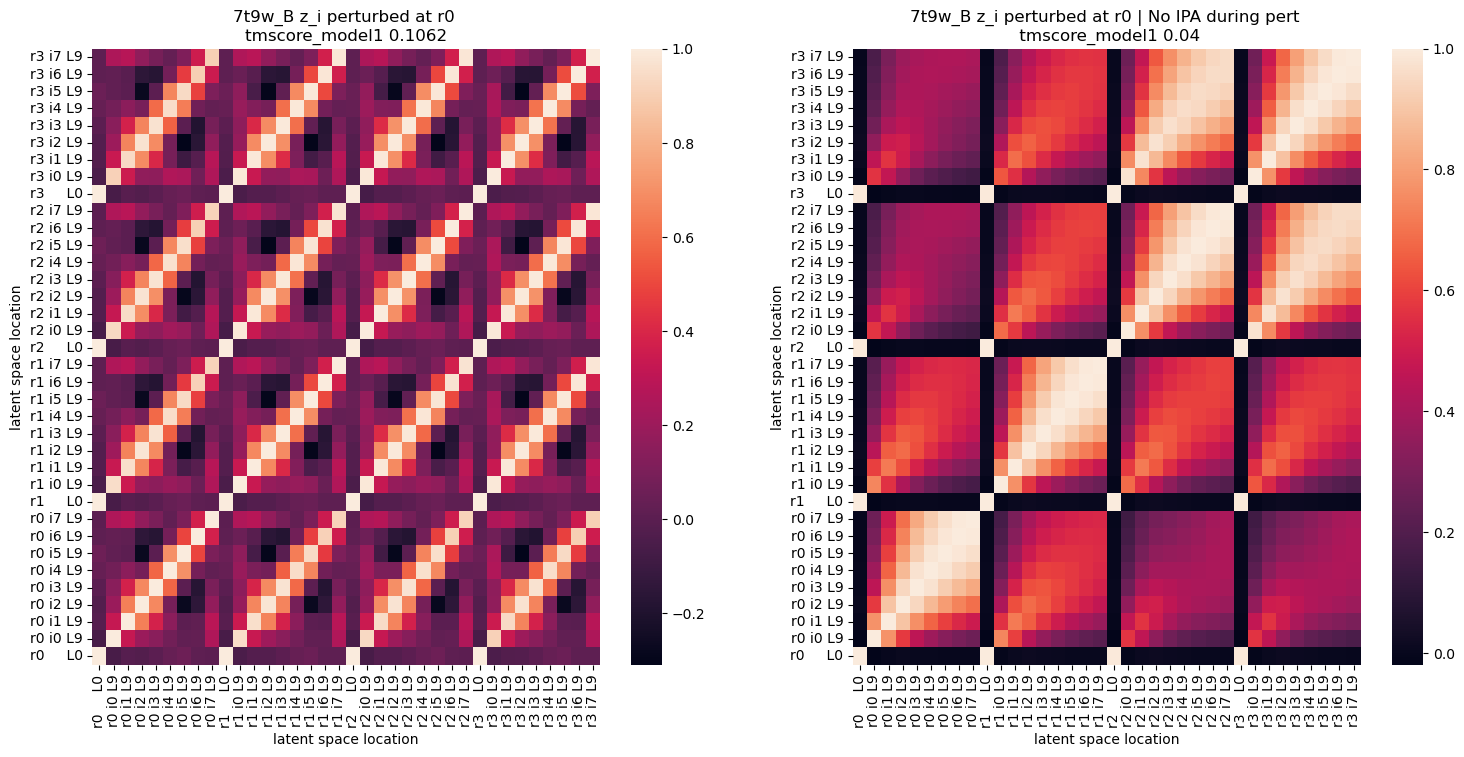

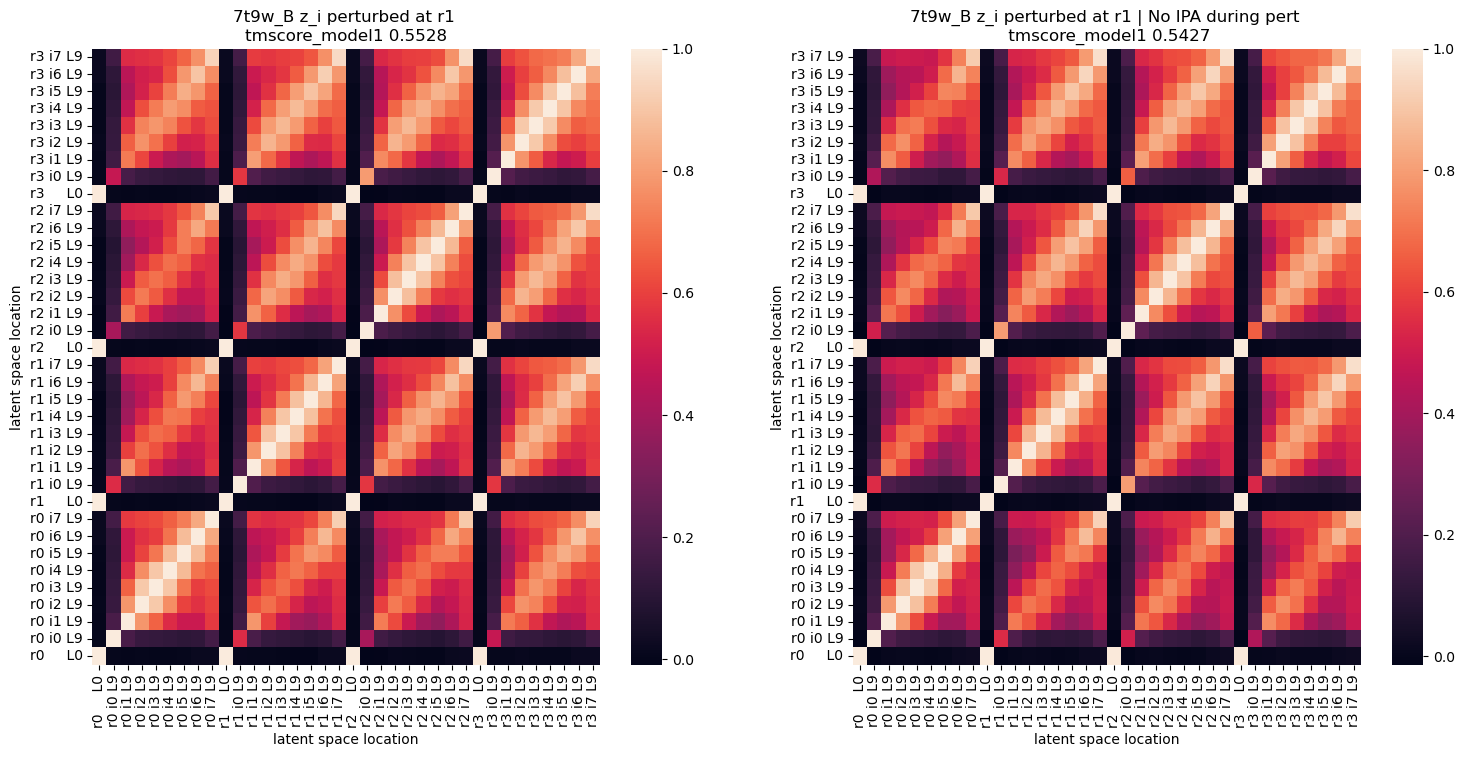

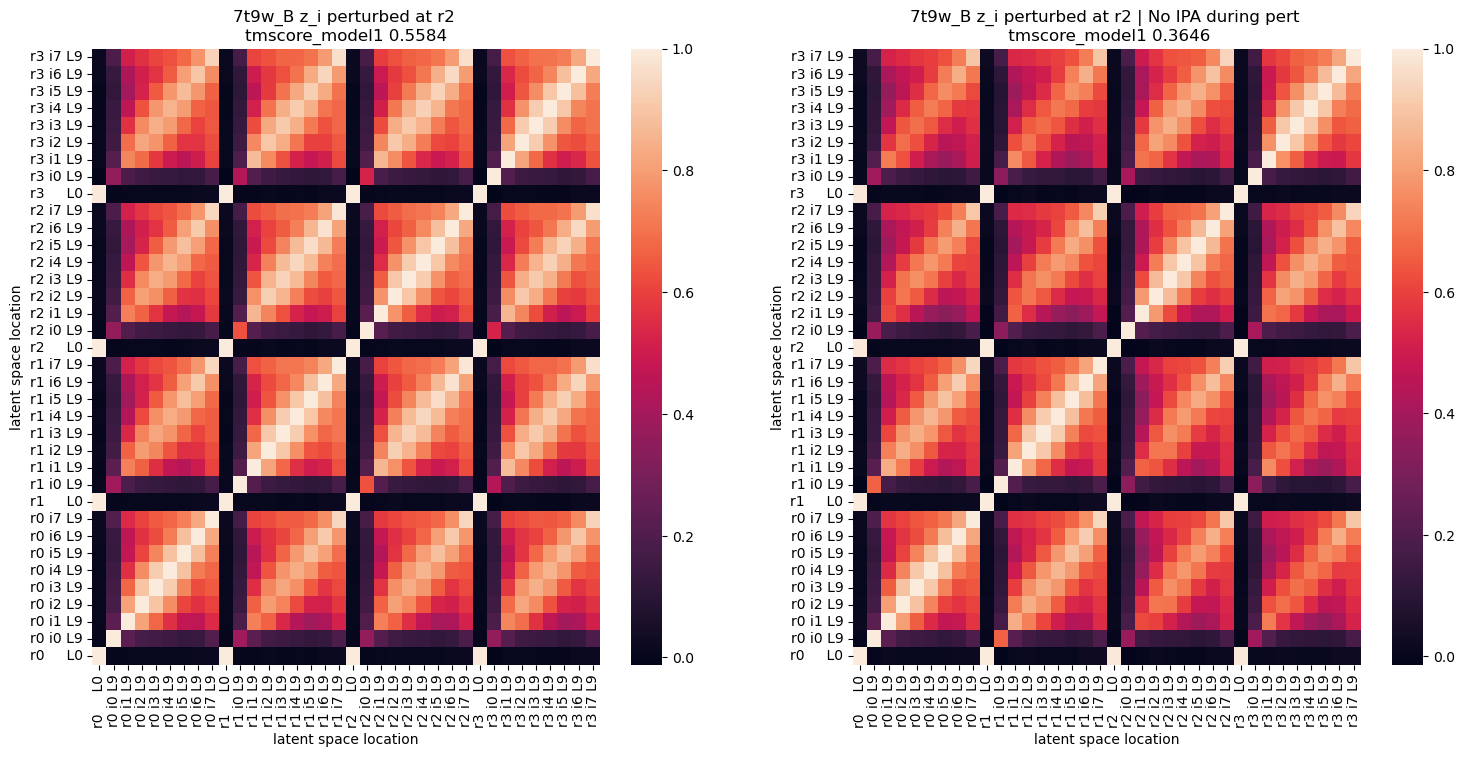

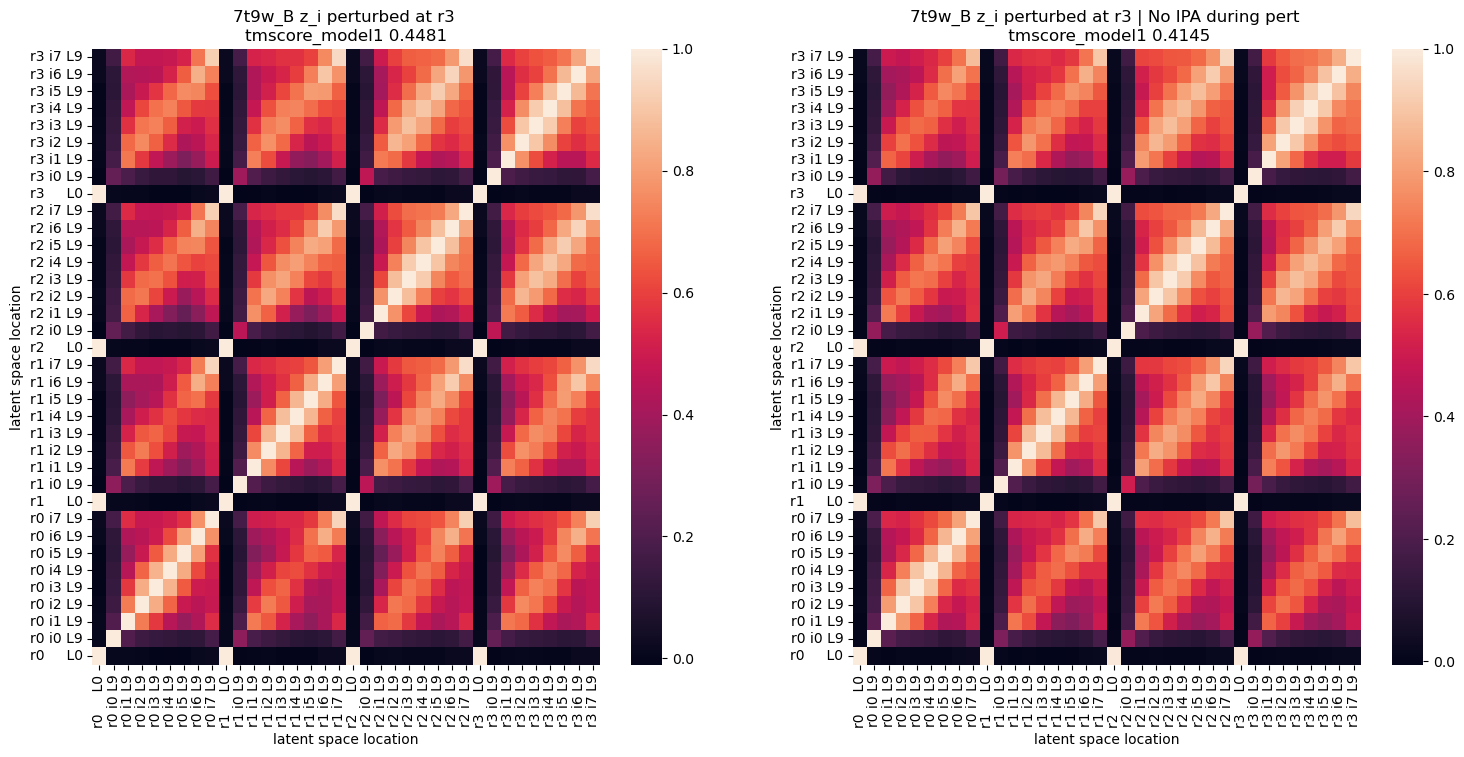

In [27]:
p = get_proteins_in_pth(PTH_zDOE)[2]
list_lines = [0,9]

for r in [0,1,2,3]:
    plt.subplot(1,2,1)
    PTH = PTH_zDOE
    plot_lspace_cos_sim_grid(p,-1,r,list_lines, PTH)
    if not r == -1:
        tm= tmscore(PTH + f'{p}_lspace_zeroedat_r_{-1}_i_{-1}/{p}_model_1_ptm_unrelaxed.pdb', PTH + f'{p}_lspace_zeroedat_r_{r}_i_{-1}/{p}_model_1_ptm_unrelaxed.pdb')
        plt.title(f'{p} z_i perturbed at r{r} \ntmscore_model1 {tm}')
    else:
        plt.title(f'{p} Unperturbed')
    
    plt.subplot(1,2,2)
    PTH = PTH_zDOE_noIPA
    plot_lspace_cos_sim_grid(p,-1,r,list_lines, PTH)
    if not r == -1:
        tm= tmscore(PTH + f'{p}_lspace_zeroedat_r_{-1}_i_{-1}/{p}_model_1_ptm_unrelaxed.pdb', PTH + f'{p}_lspace_zeroedat_r_{r}_i_{-1}/{p}_model_1_ptm_unrelaxed.pdb')
        plt.title(f'{p} z_i perturbed at r{r} | No IPA during pert \n tmscore_model1 {tm}')
    else:
        plt.title(f'{p} Unperturbed')
    plt.show()

In [84]:
import glob
from PIL import Image
if True:
    frame_folder = fig_loc
    #frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.JPG")]
    frames = []
    for i in range(37):
        frames.append(Image.open(frame_folder + f'DOE_model1_{p}_{i}.png'))
    frame_one = frames[0]
    frame_one.save(frame_folder + f"DOE_model1_{p}.gif", format="GIF", append_images=frames, save_all=True, duration=2000, loop=0)
